In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from collections import Counter
from scipy import special
from scipy.stats import beta

from conformal_utils import *
from utils.imagenet_helpers import ImageNetHierarchy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# # OPTION 1: Use ImageNet-val
logits = torch.load('/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/imagenet_val/logits.pt')
labels = torch.load('/home/eecs/tiffany_ding/code/empirical-bayes-conformal/data/imagenet_val/labels.pt')
logits = logits.numpy()
labels = labels.type(torch.LongTensor).numpy()
softmax_scores = special.softmax(logits, axis=1)

# OPTION 2: Use ImageNet-train
# logits = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_logits.pt', map_location=torch.device('cpu'))
# softmax_scores = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', map_location=torch.device('cpu'))
# labels = torch.load('/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_labels.pt', map_location=torch.device('cpu'))
# labels = labels.type(torch.LongTensor).numpy()

In [12]:
## ONLY HAVE TO RUN THIS ONCE

## Convert logits to softmax vectors (this takes a while)
# softmax_scores = special.softmax(logits, axis=1)
# torch.save(softmax_scores, 
#            '/home/eecs/tiffany_ding/code/SimCLRv2-Pytorch/.cache/logits/imagenet_train_subset_softmax.pt', 
#            pickle_protocol=4) # for saving large objects


### Some sanity checks

In [13]:
softmax_scores.shape

(50000, 1000)

In [14]:
labels.shape

(50000,)

In [15]:
min(labels), max(labels)

(0, 999)

In [16]:
# Check that the number of instances of each class
Counter(labels)

Counter({828: 50,
         800: 50,
         998: 50,
         782: 50,
         570: 50,
         900: 50,
         164: 50,
         776: 50,
         303: 50,
         967: 50,
         81: 50,
         779: 50,
         520: 50,
         441: 50,
         563: 50,
         849: 50,
         197: 50,
         885: 50,
         275: 50,
         615: 50,
         265: 50,
         196: 50,
         826: 50,
         464: 50,
         569: 50,
         131: 50,
         618: 50,
         969: 50,
         578: 50,
         507: 50,
         624: 50,
         510: 50,
         427: 50,
         997: 50,
         455: 50,
         2: 50,
         841: 50,
         866: 50,
         633: 50,
         973: 50,
         18: 50,
         613: 50,
         953: 50,
         202: 50,
         126: 50,
         596: 50,
         774: 50,
         302: 50,
         812: 50,
         96: 50,
         213: 50,
         860: 50,
         711: 50,
         516: 50,
         592: 50,
         314: 5

# Exploratory analysis

Use 5,000 instances as calibration and the remaining 45,000 as validation

1. Perform standard conformal inference and evaluate coverage
2. Perform class-balanced conformal inference and evaluate coverage


In [17]:
alpha = .1

n = len(labels)

scores = 1 - softmax_scores

In [18]:
%%time

np.random.seed(0)

# ======== SHUFFLE DATA ======== 
idx = np.random.permutation(np.arange(len(labels)))
shuffled_scores = scores[idx]
shuffled_labels = labels[idx]

CPU times: user 5.44 ms, sys: 5.64 s, total: 5.64 s
Wall time: 5.76 s


In [21]:
%%time
# ======== SPLIT DATA ======== 
num_calib = 25000
calib_scores, calib_labels = shuffled_scores[:num_calib], shuffled_labels[:num_calib]
val_scores, val_labels = shuffled_scores[num_calib:], shuffled_labels[num_calib:]

CPU times: user 6 µs, sys: 12 µs, total: 18 µs
Wall time: 22.2 µs


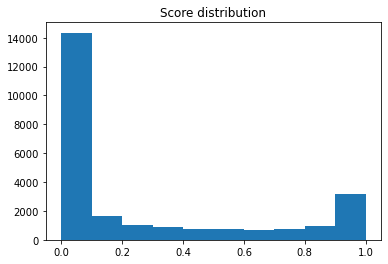

qhat: 0.9497072574186325
Standard conformal inference "marginal coverage": 89.60%


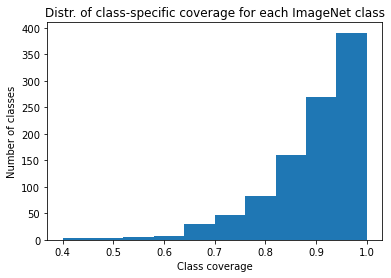

In [22]:
# ======== STANDARD CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
standard_ci_qhat = compute_qhat(calib_scores, calib_labels, alpha=alpha, plot_scores=True)
print('qhat:', standard_ci_qhat)
standard_ci_preds = create_prediction_sets(val_scores, standard_ci_qhat)

# --- Evaluate confidence sets ---
# i) Marginal coverage
marginal_cov = compute_coverage(val_labels, standard_ci_preds)
print(f'Standard conformal inference "marginal coverage": {marginal_cov*100:.2f}%')
# ii) Class-specific coverage
class_specific_cov = compute_class_specific_coverage(val_labels, standard_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

<!-- One problem I am running into is that some classes do not appear in the calibration dataset or appear only a few times, which makes $\frac{\lceil(n+1)(1-\alpha)\rceil}{n} \geq 1$, which is not a valid quantile! I'm not sure what is the best approach for dealing with those classes. One option is to just use the non-class-specific quantile obtained from standard conformal inference (practically, this works okay, but there is no theoretical guarantee). Another option is to set the quantile to $\infty$ (this is theoretically sound). -->

Class-balanced conformal inference "marginal coverage": 91.82%


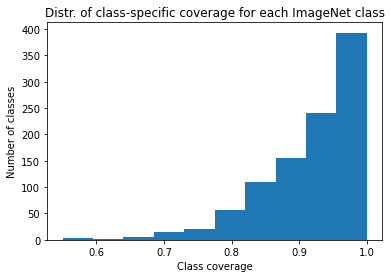

In [23]:
# ======== CLASS-BALANCED CONFORMAL INFERENCE ======== 
# --- Get confidence sets ---
default_qhat = np.inf
qhats = compute_class_specific_qhats(calib_scores, calib_labels, alpha=alpha, default_qhat=default_qhat)
# print('qhats:', qhats)
class_balanced_ci_preds = create_cb_prediction_sets(val_scores, qhats)

# --- Evaluate confidence sets ---
# i) Marginal coverage
cb_marginal_cov = compute_coverage(val_labels, class_balanced_ci_preds)
print(f'Class-balanced conformal inference "marginal coverage": {cb_marginal_cov*100:.2f}%')
# ii) Class-specific coverage
cb_class_specific_cov = compute_class_specific_coverage(val_labels, class_balanced_ci_preds)
# print(f'Standard conformal inference "class specific coverage": {class_specific_cov}')
plt.hist(cb_class_specific_cov)
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.show()

In [24]:
# plt.hist(calib_scores[2])

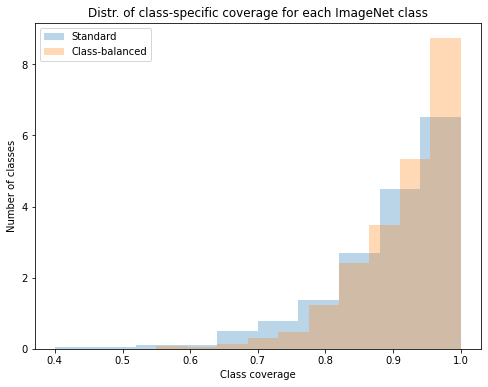

In [25]:
## Plot
plt.figure(figsize=(8,6))

# Combine histograms into one plot
plt.hist(class_specific_cov, label="Standard", alpha=.3, density=True)
plt.hist(cb_class_specific_cov, label="Class-balanced", alpha=.3, density=True)

# TODO: Fix this
# # Plot analytical distribution if we assume 
# #  (1) We have an infinite amount of validation data
# #  (2) The calibration set contains an equal number of each class [Note: I'm still working on deriving the distribution when we relax this assumption]
# # (Copied from Anastasios' code in correctness-checks.ipynb, which is linked to in Gentle Intro Section 3)
# n = num_calib / 1000 # This is where Assumption 2 is used
# l = np.floor((n+1)*alpha)
# a = n + 1 - l
# b = l
# rv = beta(a, b)
# x = np.linspace(0.4,1,1000)
# plt.plot(x, rv.pdf(x), lw=3, label=f'Theoretical distribution (assuming equal number of instances of each class)')


# Label plot
plt.xlabel('Class coverage')
plt.ylabel('Number of classes')
plt.title('Distr. of class-specific coverage for each ImageNet class')
plt.legend(loc='upper left')
plt.show()

In [26]:
np.mean(class_specific_cov)

0.8955308619009524

In [27]:
np.mean(cb_class_specific_cov)

0.9176464950326472

In [28]:
class_balanced_ci_preds

[array([458]),
 array([495]),
 array([18, 82]),
 array([ 18,  59, 309, 310, 318, 506, 885, 904, 939, 943]),
 array([135]),
 array([170, 175, 226]),
 array([ 18, 398, 424, 440, 457, 473, 487, 501, 504, 519, 582, 585, 587,
        590, 592, 622, 623, 633, 643, 650, 696, 714, 733, 737, 740, 762,
        784, 836, 837, 845, 860, 889, 960, 966]),
 array([ 18, 106, 341, 398, 462, 501, 541, 542, 556, 558, 587, 596, 623,
        634, 643, 678, 731, 733, 764, 787, 792, 889]),
 array([326]),
 array([891]),
 array([35, 36]),
 array([718]),
 array([269, 270, 273]),
 array([300]),
 array([478, 519, 529, 728]),
 array([308]),
 array([101, 385, 386]),
 array([ 18, 633]),
 array([445, 529, 842, 978]),
 array([939, 943]),
 array([ 18, 418, 473, 485, 506, 556, 622, 623, 626, 633, 650, 710, 714,
        733, 745, 767, 771, 818]),
 array([322]),
 array([ 18, 106, 170, 175, 226, 229, 257, 273, 341, 374, 445, 463, 501,
        556, 623, 633, 643, 728, 733, 912]),
 array([484]),
 array([779]),
 array([366]),

In [29]:
standard_ci_preds

[array([458]),
 array([495]),
 array([82]),
 array([939, 941, 943, 945, 948, 953]),
 array([135]),
 array([175]),
 array([424, 440, 487, 737, 740, 784]),
 array([542, 731]),
 array([326]),
 array([891]),
 array([35]),
 array([718]),
 array([258, 270]),
 array([300]),
 array([478]),
 array([308]),
 array([101, 385, 386]),
 array([18]),
 array([842]),
 array([939]),
 array([626, 650, 710]),
 array([322]),
 array([229]),
 array([484]),
 array([779]),
 array([366]),
 array([440, 907]),
 array([207, 213]),
 array([724, 780]),
 array([753]),
 array([480]),
 array([508]),
 array([209]),
 array([900]),
 array([785]),
 array([696, 710]),
 array([510]),
 array([667]),
 array([781]),
 array([320]),
 array([973]),
 array([440]),
 array([470]),
 array([538, 580, 727]),
 array([628]),
 array([107]),
 array([332]),
 array([126, 292]),
 array([629]),
 array([484, 780, 914]),
 array([367]),
 array([558]),
 array([ 28, 119]),
 array([682]),
 array([259]),
 array([153]),
 array([462]),
 array([548]),
 ar

# Save output

We now create an 1000 x 2 array where row i = [# of times class i appears in validation set, # of times class i is included to conformal set prediction when class i is true label]. Note that the second element is equal to (# of times class i appears in validation set)*(observed class coverage under standard conformal inference).

This array will be fed into the `deconvolveR` package to estimate the distribution of class coverage under standard conformal inference

In [17]:
# Count the number of instances of each class in the validation set
class_cts = Counter(val_labels)

# Create array
X = np.zeros((1000,2))
for i in range(len(X)):
    X[i,:] = [class_cts[i], class_cts[i]*cb_class_specific_cov[i]]
    
# Save array
save_to = "data/standard_conformal_class_coverage.csv"
np.savetxt(save_to, X, delimiter=",")
print(f'Saved array to {save_to}')

Saved array to data/standard_conformal_class_coverage.csv


Save the cutoffs (quantiles) for each class, as well as the class-specific coverages. This used to create the json file that I use to create https://observablehq.com/d/5bb27b3940f0bc23

In [18]:
save_to = 'data/class_balanced_qhats.npy'
np.save(save_to, qhats)
print(f'Saved array of qhats to {save_to}')

Saved array of qhats to data/class_balanced_qhats.npy


In [19]:
save_to = 'data/class_specific_coverages.npy'
np.save(save_to, cb_class_specific_cov)
print(f'Saved class-specific coverages to {save_to}')

Saved class-specific coverages to data/class_specific_coverages.npy


## Do semantically similar classes have similar qhats? 

Method for computing graph distance:https://www.quora.com/Whatll-be-the-best-method-to-find-the-distances-between-every-two-nodes-in-a-node-tree
```
Now given any two nodes A and B, we can find their deepest common ancestor with the following algorithm:

If the depth of A is greater than the depth of B, find the common ancestor of parent(A) and B.
Otherwise if the depth of B is greater than the depth of A, find the common ancestor of A and parent(B).
Otherwise, if A and B are the same node, then A is the deepest common ancestor.
Otherwise, find the common ancestor of parent(A) and parent(B).
Once you have the deepest common ancestor, C, the distance between A and B is:

depth(A) + depth(B) - 2* depth(C)
```

In [90]:
hier_info_path = 'data/imagenet_hierarchy/'
in_hier = ImageNetHierarchy(hier_info_path)

accordion, piano accordion, squeeze box has multiple parents: ['keyboard instrument', 'free-reed instrument']
bakery, bakeshop, bakehouse has multiple parents: ['shop, store', 'workplace, work']
baseball has multiple parents: ['baseball equipment', 'ball']
basketball has multiple parents: ['basketball equipment', 'ball']
bath towel has multiple parents: ['towel', 'bath linen']
brassiere, bra, bandeau has multiple parents: ['undergarment, unmentionable', "woman's clothing"]
bulletproof vest has multiple parents: ['vest, waistcoat', 'body armor, body armour, suit of armor, suit of armour, coat of mail, cataphract']
computer keyboard, keypad has multiple parents: ['keyboard', 'data input device, input device']
croquet ball has multiple parents: ['ball', 'croquet equipment']
face powder has multiple parents: ['makeup, make-up, war paint', 'powder']
golf ball has multiple parents: ['golf equipment', 'ball']
golfcart, golf cart has multiple parents: ['motor vehicle, automotive vehicle', 'gol

In [91]:
# Test code for computing depths

# def print_depths(curr_node):
#     '''
#     Prints depths of children of current node
#     '''
#     print([f'{c.name}: {c.depth}' for c in curr_node.children])
# #     print([f'{c.depth}' for c in curr_node.children])
#     for c in curr_node.children:
#         print('c', c)
#         print_depths(c)

# root_node = in_hier.get_node("n00001740") 
# print_depths(root_node)

Each list corresponds to the depths of the children of a given node, so we expect the numbers to all be the same. This is generally true, but there are a few weird cases where this is not true. This is possibly because some nodes appear multiple times in ImageNet? Not sure. But I think it not worth spending a lot of time debugging this currently since my code seems operational for the most part. 

In [ ]:
# in_hier.get_node("n00001740").children

In [99]:
# Sanity checks

node1 = in_hier.get_node("n03814906") # necklace
node2 = in_hier.get_node("n04458633") # totem pole
node3 = in_hier.get_node("n07742313") # Granny Smith
node4 = in_hier.get_node("n07745940") # strawberry

in_hier.get_deepest_common_ancestor(node3, node4)

/Users/tiffanyding/Desktop/Berkeley/Conformal inference/empirical-bayes-conformal/utils/imagenet_helpers.py:372: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(class_ranges[i].intersection(class_ranges[j])) == 0,


Name: (edible fruit), ImageNet Class: (-1), Descendants: (9)

In [100]:
print(in_hier.compute_distance(node1, node1)) # Expected answer: 0
print(in_hier.compute_distance(node1, node2)) # Expected answer: 6
print(in_hier.compute_distance(node3, node4)) # Expected answer: 5

0
5
5


### Results

In [136]:
%%time 

# 1. For all leaf nodes, compute graph distance and difference between qhats. Then calculate correlation

leaf_nodes = [node for node in in_hier.tree if in_hier.get_node(node).descendant_count_in == 0]

all_combinations = sum([[(n1, n2) for n1 in leaf_nodes] for n2 in leaf_nodes], [])
all_combinations = [(n1, n2) for n1, n2 in all_combinations if n1 != n2] # Filter out n1 == n2

dists = [in_hier.compute_distance(in_hier.get_node(n1), in_hier.get_node(n2)) for n1, n2 in all_combinations]
qhat_diffs = [abs(qhats[in_hier.get_node(n1).class_num] - qhats[in_hier.get_node(n2).class_num])
              for n1, n2 in all_combinations]

/Users/tiffanyding/Desktop/Berkeley/Conformal inference/empirical-bayes-conformal/utils/imagenet_helpers.py:375: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(class_ranges[i].intersection(class_ranges[j])) == 0,


CPU times: user 43.6 s, sys: 2.79 s, total: 46.4 s
Wall time: 48 s


In [154]:
dists = np.array(dists)
qhat_diffs = np.array(qhat_diffs)

np.corrcoef(dists, qhat_diffs)

array([[1.        , 0.04959895],
       [0.04959895, 1.        ]])

In [156]:
# 2. Compare qhat differences between siblings (distance == 2) vs. between other between non-sibling nodes

sibling_idx = [idx for idx in range(len(dists)) if dists[idx] == 2]

sib_diffs = qhat_diffs[sibling_idx]
nonsib_diffs = qhat_diffs[[idx for idx in range(len(dists)) if idx not in sibling_idx]]

In [167]:
n = len(sib_diffs)
print(f'Mean qhat difference for sibling nodes: {np.mean(sib_diffs):.3f} (std dev: {np.std(sib_diffs) / np.sqrt(n):.3f})')
print(f'Mean qhat difference for non-sibling nodes: {np.mean(nonsib_diffs):.3f} (std dev: {np.std(nonsib_diffs) / np.sqrt(n):.3f})')

Mean qhat difference for sibling nodes: 0.217 (std dev: 0.005)
Mean qhat difference for non-sibling nodes: 0.245 (std dev: 0.006)


**Conclusion**: Semantically similar classes do not seem to have qhat values that are close to each other